In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import sys
sys.path.append('..')
import utils, selex_dca
from utils import one_hot
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

/home/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_id = "R02N"

In [3]:
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float64

In [4]:
sequences = utils.sequences_from_file(experiment_id, round_id)

In [5]:
sequences_oh = [one_hot(sequences).to(dtype=dtype)]

In [6]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])

In [7]:
fi0, fij0, total_reads0 = utils.frequences_from_sequences_oh(sequences_oh[0])
total_reads = torch.tensor([total_reads0]).to(dtype)

In [8]:
from importlib import reload
reload(utils)
reload(energy_models)
reload(selex_distribution)
reload(callback)

<module 'callback' from '/home/scrotti/Aptamer2025py/experiments/../callback.py'>

In [15]:
L, q = sequences_oh[0][0].shape

# k = torch.log(fi0)
# k = torch.randn(L, q, dtype=dtype) * 1e-4
# K = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4
# K = utils.zerosum_gauge_couplings(fij0)
k = torch.zeros(L, q, dtype=dtype)
K = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.Potts(K, k)

model = selex_distribution.MultiRoundDistribution(Ns0).to(device)

In [16]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype, device=device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype, device=device)

# callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [17]:
reload(callback)
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback()]

In [28]:
n_sweeps = 10
lr = 0.01
max_epochs = 2000

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                                       …

KeyboardInterrupt: 

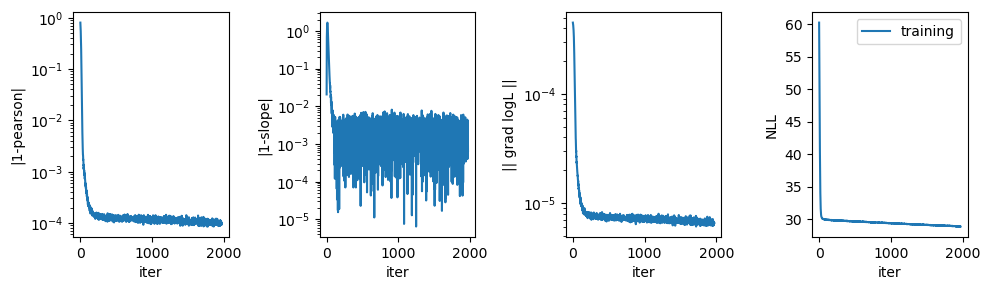

In [23]:
callbacks[0].plot();

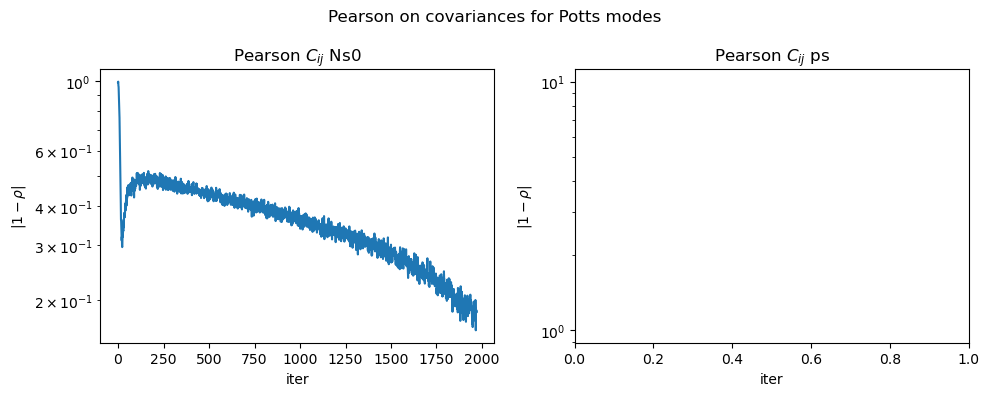

In [24]:
fig, axes = callbacks[1].plot()
# axes[0].set_ylim((0.9,1.01))

In [25]:
t = 0
fi, fij, _ = utils.frequences_from_sequences_oh(data_loaders[t].get_batch())
pi, pij, _ = utils.frequences_from_sequences_oh(chains[t])
callback.compute_potts_covariance(fi, fij, pi, pij)

0.8159330967614111

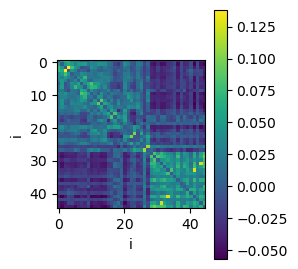

In [27]:
potts_zerosum = Ns0.set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
h = potts_zerosum.h.detach().cpu()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()